In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import os
!pip install mglearn
import mglearn

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 7

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile

from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from sklearn.tree import export_graphviz
import graphviz
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import layers
from tensorflow.keras.utils import plot_model
#!pip install --upgrade tensorflow
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
curr_table=pd.read_csv("5th_yr.csv")
curr_table=curr_table.set_index("Id")
curr_table.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
Id,,,,,,,,,,,,,,,,,,,,,
1188,0.30019,0.13293,0.38325,3.8831,89.916,0.86116,0.37196,6.2473,1.3258,0.83044,...,0.245720,0.36148,0.75428,0,13.076,6.5019,32.5990,11.196,3.0762,0
1654,0.089987,0.56987,0.097846,6.3579,54.84,0,0.10076,0.75477,0.78787,0.43012,...,0.104040,0.20921,0.88032,1.2791,?,7.997,8.4604,43.142,0.89136,0
3864,0.13392,0.12496,0.63756,6.2914,112.91,0.34113,0.16677,6.7318,1.1352,0.84119,...,0.119080,0.1592,0.88092,0.005311,4.1466,6.2483,35.4520,10.296,5.1271,0
3578,0.019501,0.7923,0.008121,1.0177,-54.871,0,0.023128,0.26215,1.705,0.2077,...,0.045674,0.09389,0.98657,1.453,6.9627,8.7576,98.4780,3.7064,3.2056,0
2028,0.19983,0.33871,0.91824,23.042,32.034,0,0.24716,1.9524,4.8863,0.66129,...,0.062723,0.30218,0.94944,0.44868,9.5699,12.39,3.1118,117.3,121.84,0


In [ ]:
curr_table.replace('?', np.nan, inplace = True)
curr_table.iloc[:, :-1] = curr_table.iloc[:, :-1].astype(np.float64)

# fill missing value with median
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
curr_table.loc[:, curr_table.columns!='Bankrupt'] = imp_mean.fit_transform(curr_table.loc[:, curr_table.columns!='Bankrupt'])


<ipython-input-4-bce749689767>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curr_table.iloc[:, :-1] = curr_table.iloc[:, :-1].astype(np.float64)


In [ ]:
train_describe_std =curr_table.describe().loc['std',:]
extreme_cols = train_describe_std[train_describe_std>10000].index.values
regular_cols = [col for col in curr_table.columns[:-1] if col not in extreme_cols]

<Axes: >

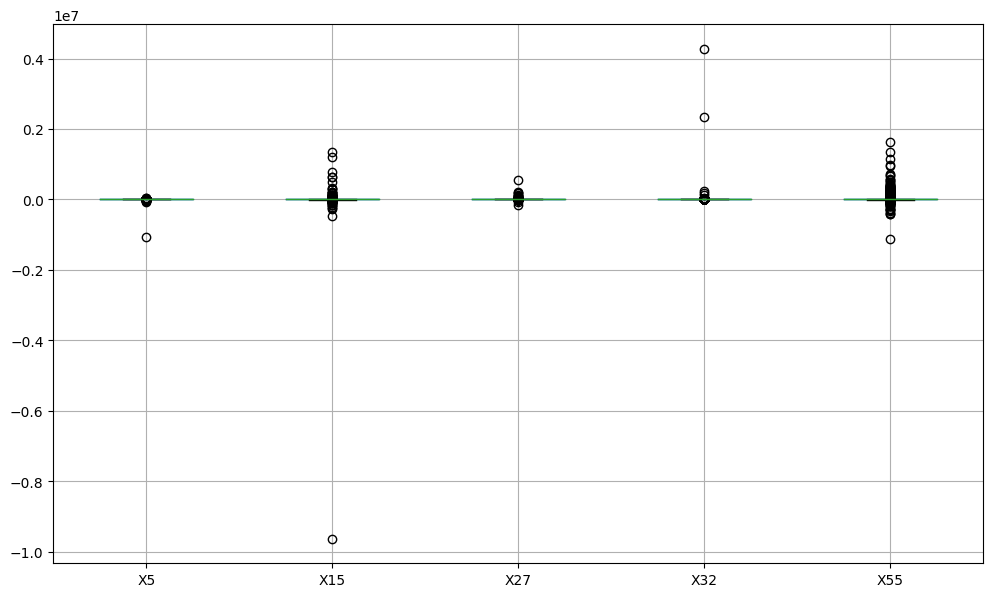

In [ ]:
curr_table.loc[:,extreme_cols].boxplot()

<Axes: >

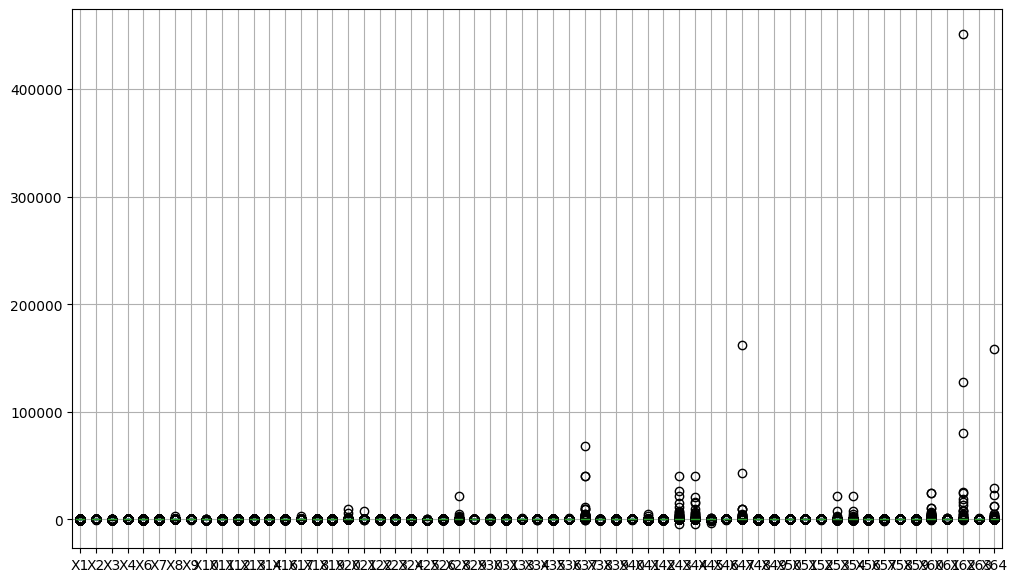

In [ ]:
curr_table.loc[:, regular_cols].boxplot()

(array([4510.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         308.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

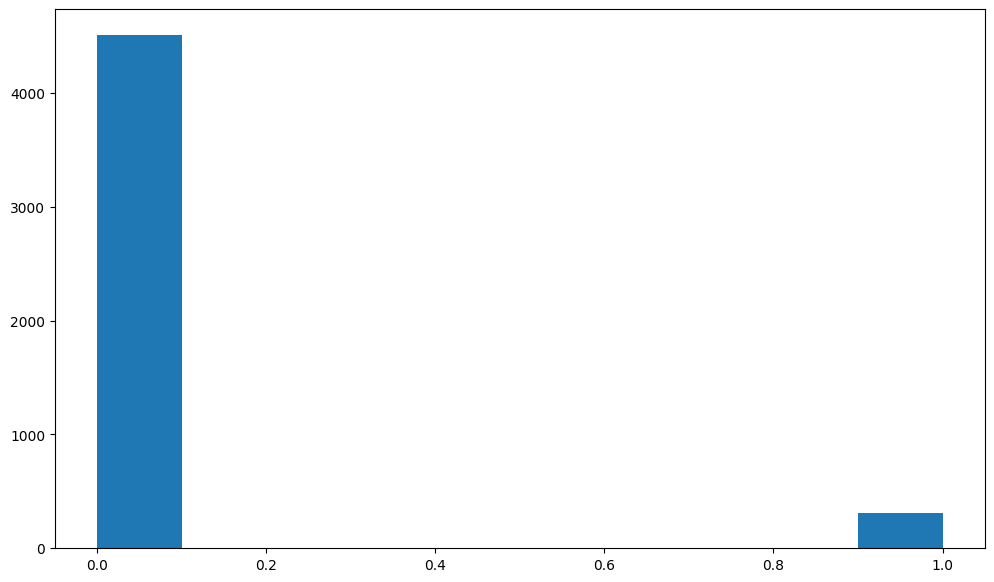

In [ ]:
plt.hist(curr_table.iloc[:,-1])

In [ ]:
def drop_numerical_outliers(df, z_thresh=3):
    print('Before dropping outliers: ', df.shape)
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df.iloc[:,:-1].select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce=False) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df.drop(df.index[~constrains], inplace=True)
    print('After dropping outliers: ', df.shape)

In [ ]:
"""
Need to split train test sets before upsampling
We only upsample train set
"""
def upsampling_minority(X, y):
    # setting up testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

    print('Before upsampling: training data shape', X_train.shape, 'test data shape', X_test.shape)
    print("Unbalanced training data{}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(y_train))}))

    sm = SMOTE(random_state=10)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    print('Finished upsampling: training data shape', X_train.shape, 'test data shape', X_test.shape)
    print("Balanced training data {}".format({n: v for n, v in zip(['Not Bankrupt', 'Bankrupt'], np.bincount(y_train))}))

    return X_train, X_test, y_train, y_test

In [ ]:
"""
Plot test score heatmap of parameter sets
"""
def plot_heatmap(grid, params):
    results = pd.DataFrame(grid.cv_results_)
    keys = list(params.keys())
    scores = np.array(results.mean_test_score).reshape(len(params[keys[1]]),
                                                             len(params[keys[0]]))
    plt.figure()
    mglearn.tools.heatmap(scores, xlabel=keys[0], xticklabels=params[keys[0]],
                          ylabel=keys[1], yticklabels=params[keys[1]],
                          cmap="viridis", fmt='%0.5f')
    plt.show()

In [ ]:
"""
Grid search for gradient boosting model
"""
def gbm_grid_search(original_gbm, X_train, y_train, score_method, show_plots, predictors):

    # tune n_estimators, max_depth
    param_trees = {'n_estimators': [i for i in range(10, 101, 30)],
                  'max_depth': [i for i in range(2,6,1)]}
    gsearch1 = GridSearchCV(estimator = original_gbm,
                            param_grid = param_trees,
                            scoring=score_method,
                            n_jobs=-1,

                            cv=5
                           )
    gsearch1.fit(X_train, y_train)
    if show_plots:
        print('Best parameters: ', gsearch1.best_params_)
        plot_heatmap(gsearch1, param_trees)

    # tune min_samples_split, min_samples_leaf
    param_tree2 = {'min_samples_split': [i for i in range(10,51,20)],
                  'min_samples_leaf': [i for i in range(10,51,20)]}
    gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_,
                            param_grid = param_tree2,
                            scoring=score_method,
                            n_jobs=-1,

                            cv=5)
    gsearch2.fit(X_train, y_train)
    if show_plots:
        print('Best parameters: ', gsearch2.best_params_)
        plot_heatmap(gsearch2, param_tree2)

    # tune learning_rate
    n_estimator = gsearch1.best_params_['n_estimators']
    param_tree3 = [{'learning_rate': [0.1],
                  'n_estimators': [n_estimator]},
                  {'learning_rate': [0.1*5],
                  'n_estimators': [n_estimator//5]},
                  {'learning_rate': [0.1/10],
                  'n_estimators': [n_estimator*10]}]
    gsearch3 = GridSearchCV(estimator = gsearch2.best_estimator_,
                            param_grid = param_tree3,
                            scoring=score_method,
                            n_jobs=-1,

                            cv=5)
    gsearch3.fit(X_train, y_train)
    print('Best score: ', gsearch3.best_score_)

    # best estimator
    gbm1 = gsearch3.best_estimator_

    # plot result tree and feature importance
    if show_plots:
        print('Best parameters: ', gsearch3.best_params_)
        #print('Show Tree:\n')
        #export_graphviz(gbm1.estimators_[0][0])
        #with open("tree.dot") as f:
            #dot_graph = f.read()
        #display(graphviz.Source(dot_graph))

        print('Show Feature Importance:\n')
        feat_imp = pd.Series(data=gbm1.feature_importances_, index=predictors).sort_values(ascending=False)
        plt.figure()
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()

    return gbm1

In [ ]:
def MyModel(X_train, y_train, show_plots=True, score_method='recall'):

    """
    Naive Bayes
    """
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    print('Finished training Naive Bayes...')

    """
    Logistic Regression
    """
    params_logit = {'polynomialfeatures__degree': [1, 2],
               'selectpercentile__percentile': [50, 100],
               'logisticregression__C': [0.01, 1, 100]}
    pipe_logit = make_pipeline(PolynomialFeatures(include_bias=False),
                               StandardScaler(), SelectPercentile(),
                               LogisticRegression(max_iter=1000))
    lsearch = GridSearchCV(estimator=pipe_logit,
                           scoring='recall',
                           param_grid=params_logit,
                           cv=5,

                           n_jobs=-1)
    lsearch.fit(X_train, y_train)
    lr = lsearch.best_estimator_
    print('Finished training Logistic Regression...')

    """
    Support Vector Machine
    """
    params_svc = [{'svc__kernel' : ['rbf'],
             'svc__gamma' : [0.01, 0.1, 1, 10, 100],
             'svc__C' : [0.01, 0.1, 1, 10, 100]},
             {'svc__kernel' : ['linear'],
             'svc__C' : [0.01, 0.1, 1, 10, 100]}]
    pipe_svc = make_pipeline(MinMaxScaler(), SVC()) # no need for polynomialfeatures
    ssearch = GridSearchCV(estimator=pipe_svc,
                           scoring='recall',
                           param_grid=params_svc,
                           cv=5,

                           n_jobs=-1)
    ssearch.fit(X_train, y_train)
    svc = ssearch.best_estimator_
    print('Finished training Support Vector Machine...')

    """
    GBM
    """
    gbm0 = GradientBoostingClassifier(random_state=10)
    gbm0.fit(X_train, y_train)
    gbm1 = gbm_grid_search(gbm0, X_train, y_train,
                           score_method=score_method, show_plots=show_plots, predictors = X.columns)
    print('Finished training Gradient Boosting...')

    """
    NN
    """
    #nn = nn_grid_search(X_train, y_train, score_method='recall')
    #print('Finished training Neural Network...')

    # all models
    models = [clf, lr, svc, gbm1]

    return models

In [ ]:
data = curr_table.copy()

In [ ]:
y = data.loc[:,'Bankrupt']
X = data.loc[:, data.columns!='Bankrupt']
X_train, X_test, y_train, y_test = upsampling_minority(X, y)

Before upsampling: training data shape (3613, 64) test data shape (1205, 64)
Unbalanced training data{'Not Bankrupt': 3399, 'Bankrupt': 214}
Finished upsampling: training data shape (6798, 64) test data shape (1205, 64)
Balanced training data {'Not Bankrupt': 3399, 'Bankrupt': 3399}


Finished training Naive Bayes...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Finished training Logistic Regression...
Finished training Support Vector Machine...
Best parameters:  {'max_depth': 5, 'n_estimators': 100}


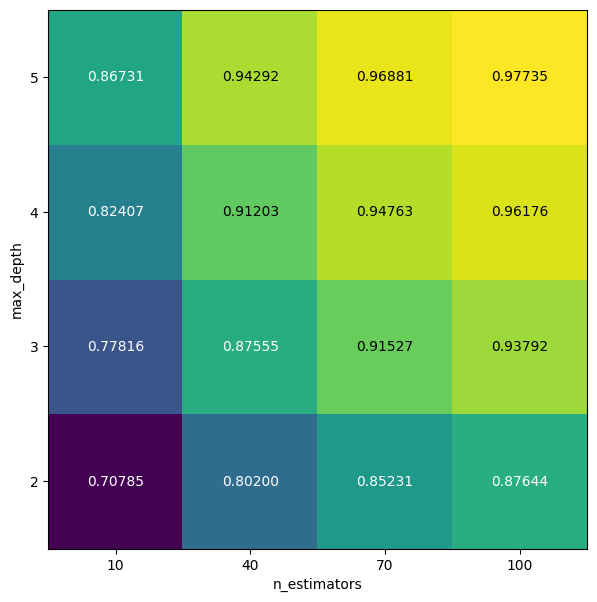

Best parameters:  {'min_samples_leaf': 10, 'min_samples_split': 30}


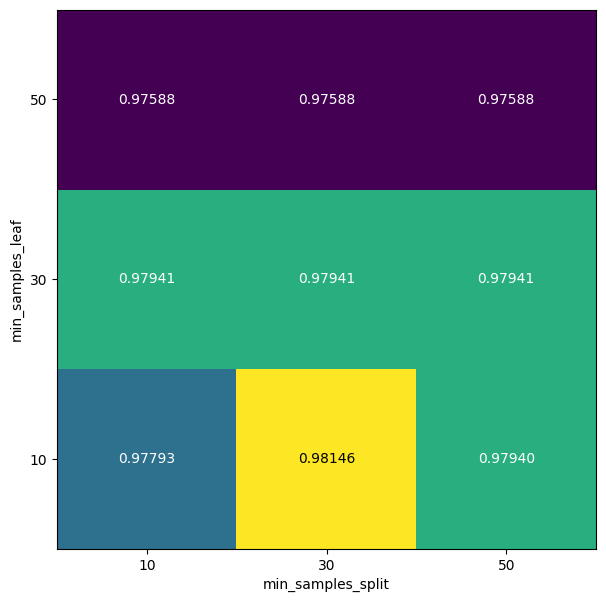

Best score:  0.9814649571168674
Best parameters:  {'learning_rate': 0.1, 'n_estimators': 100}
Show Feature Importance:



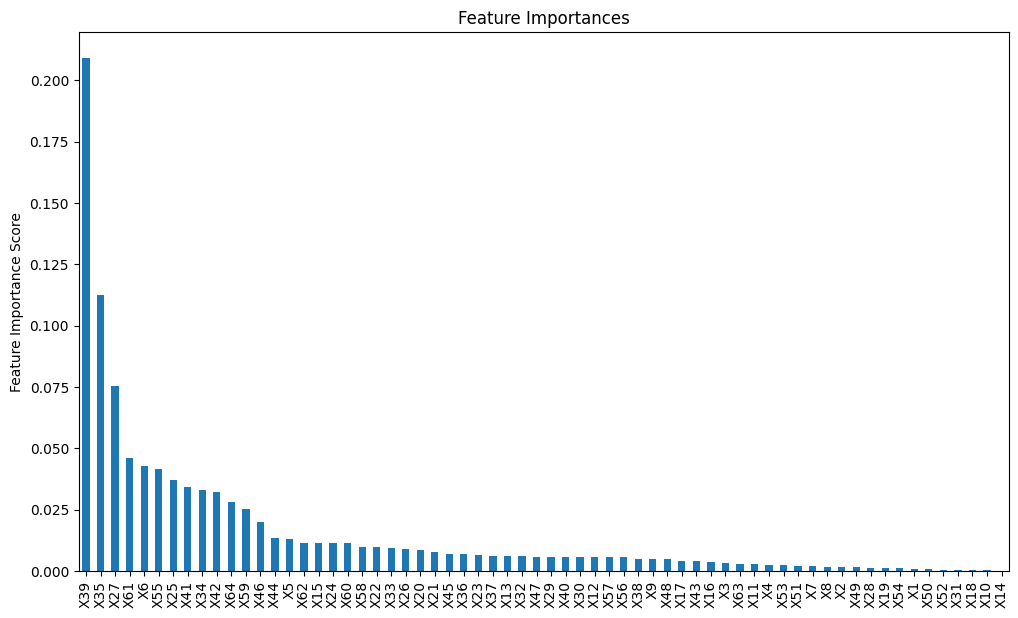

Finished training Gradient Boosting...


In [ ]:
mymodels = MyModel(X_train, y_train)

In [ ]:
feat_imp = pd.Series(data=gbm1.feature_importances_, index=predictors).sort_values(ascending=False)
plt.figure()
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

NameError: name 'gbm1' is not defined

In [ ]:
def CompareModels(models, curve, show_plots=True, X_test=X_test, y_test=y_test):
    final_report = pd.DataFrame(index=['clf', 'lr', 'svc', 'gbm'],
                            columns=['accuracy', 'precision', 'recall', 'f1',  'f1_macro'])

    for i in range(len(models)):
        model = models[i]
        name = final_report.index[i]
        report = pd.DataFrame(classification_report(y_test, model.predict(X_test), output_dict=True)).transpose()
        final_report.loc[name, :] = [report.loc['accuracy', 'support'],
                                 report.loc['1', 'precision'],
                                 report.loc['1', 'recall'],
                                 report.loc['1', 'f1-score'],
                                 report.loc['macro avg', 'f1-score']]

    print("Model Comparison Report:\n", final_report)


    def plot_curve(model, model_name, marker, decision_function, curve):
        if decision_function:
            precision, recall, thresholds = curve(y_test, model.decision_function(X_test))
            close = np.argmin(np.abs(thresholds))
        else:
            precision, recall, thresholds = curve(y_test, model.predict_proba(X_test)[:,1])
            close = np.argmin(np.abs(thresholds - 0.5))

        plt.plot(precision, recall, label=model_name)
        plt.plot(precision[close], recall[close], marker, c='k', markersize=10,
                label="threshold "+model_name, fillstyle='none', mew=2)

    # roc_auc plot
    if show_plots:
        plt.figure()
        plt.title('Curve')
        plot_curve(models[1], 'lr', 'o', False, curve)
        plot_curve(models[2], 'svc', '^', True, curve)
        plot_curve(models[3], 'gbm', 'D', False, curve)
        #plot_curve(models[4], 'nn', '*', False, curve)
        plt.legend()
        plt.show()


Model Comparison Report:
      accuracy precision    recall        f1  f1_macro
clf  0.902075  0.166667   0.06383  0.092308  0.520277
lr   0.891286  0.330275  0.382979   0.35468  0.647662
svc  0.857261      0.25  0.414894     0.312  0.616185
gbm  0.915353  0.462264  0.521277      0.49  0.721923


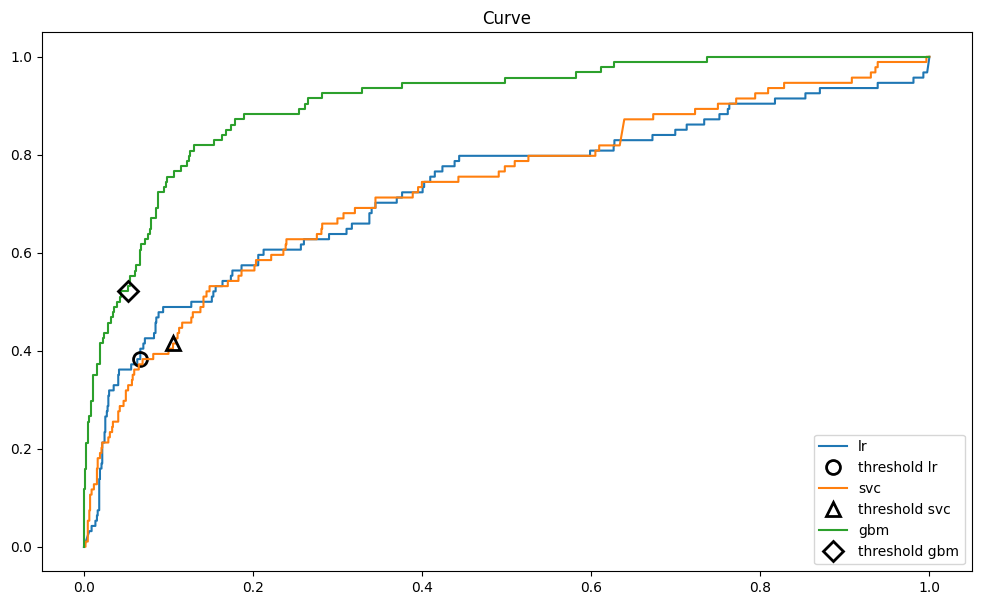

In [ ]:
CompareModels(mymodels, roc_curve)

In [ ]:
mymodels[-1]

GradientBoostingClassifier(max_depth=5, min_samples_leaf=10,
                           min_samples_split=30, random_state=10)

In [ ]:
gbm_model = mymodels[-1]

# Compute probabilities of bankruptcy using the GBM model
bankruptcy_probabilities = gbm_model.predict_proba(X_test)[:, 1]  # Get the probability of being 'Bankrupt'

# If you want to attach these probabilities back to your test dataset for easier interpretation:
X_test_with_prob = X_test.copy()
X_test_with_prob['Bankruptcy_Probability'] = bankruptcy_probabilities

# Display the first few rows to verify
print(X_test_with_prob.head())

            X1        X2       X3      X4        X5        X6        X7  \
Id                                                                        
4616  0.298850  0.720710  0.39629  3.1584   31.5060 -0.310720  0.353320   
1404  0.007381  0.456790  0.21947  1.4805    6.4083  0.000000  0.009113   
5518 -0.030892  0.909150  0.00681  1.0075 -107.2600  0.000000 -0.030892   
3657  0.100240  0.385350  0.45721  2.1875   -6.1659  0.000000  0.119320   
1952  0.070016  0.073127  0.49647  7.7976  167.4300  0.038322  0.073830   

             X8      X9       X10  ...       X56       X57      X58       X59  \
Id                                 ...                                          
4616   0.387520  2.9864  0.279290  ...  0.155120  1.070000  0.88182  1.841800   
1404   1.189200  1.3505  0.543210  ...  0.006549  0.013588  0.99326  0.000000   
5518   0.099933  1.3307  0.090853  ...  0.320920 -0.340030  0.71193  0.000000   
3657   1.595000  1.8326  0.614650  ...  0.070683  0.163080  0.93611  

In [ ]:
X_train.shape

(6798, 64)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Standardize the training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Fit PCA on the standardized training data
pca = PCA(n_components=0.95) # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Generate new samples in the PCA space
num_samples = 36
new_samples_pca = np.random.randn(num_samples, X_pca.shape[1])

# Inverse transform to get back to the original feature space
new_samples_original_space = pca.inverse_transform(new_samples_pca)
new_samples = scaler.inverse_transform(new_samples_original_space)

# Create a DataFrame for the new samples
new_samples_df = pd.DataFrame(new_samples, columns=X_train.columns)

print(new_samples_df)

          X1        X2        X3         X4           X5         X6  \
0   2.424763  2.129410 -0.339706 -10.161400 -1060.980713   1.006771   
1  -0.061765 -3.837552  0.417189  11.744933 -1729.710733   4.462095   
2  -1.348311  1.535495  0.644797  21.193150   481.425278  -2.996076   
3   5.795885  2.062755 -0.172978  -6.370317 -1478.927187   4.113195   
4   1.145733 -1.908446 -0.554124   5.166701   297.786461   4.272541   
5   7.696735 -2.386234 -0.536335  11.669653   398.010915  11.323880   
6   2.924967  5.870809  0.127881  -4.287710   828.956447  -2.466958   
7   0.089228 -2.448840  0.026454   3.051522 -1323.993420   3.517728   
8  -2.709117 -5.735023  0.922175  -2.913348 -1211.146555   3.475584   
9  -4.250934  5.731806 -0.429905   3.884575  2220.790110  -9.165238   
10 -0.302996  4.295361 -0.280166 -10.499011  -750.134445  -4.111090   
11 -0.867527  1.830167  0.008246   1.910056   551.358748  -2.300295   
12  2.209321 -4.029761 -0.276400   0.115598   765.846577   7.730160   
13 -3.

In [ ]:
gbm_model = mymodels[-1]

# Compute probabilities of bankruptcy using the GBM model
bankruptcy_probabilities = gbm_model.predict_proba(new_samples_df)[:, 1]  # Get the probability of being 'Bankrupt'

# If you want to attach these probabilities back to your test dataset for easier interpretation:
new_samples_df_prob = new_samples_df.copy()
new_samples_df_prob['Bankruptcy_Probability'] = bankruptcy_probabilities

# Display the first few rows to verify
print(new_samples_df_prob.head())

         X1        X2        X3         X4           X5        X6        X7  \
0  2.424763  2.129410 -0.339706 -10.161400 -1060.980713  1.006771  3.866756   
1 -0.061765 -3.837552  0.417189  11.744933 -1729.710733  4.462095 -4.083210   
2 -1.348311  1.535495  0.644797  21.193150   481.425278 -2.996076  0.051151   
3  5.795885  2.062755 -0.172978  -6.370317 -1478.927187  4.113195  7.391298   
4  1.145733 -1.908446 -0.554124   5.166701   297.786461  4.272541 -3.166385   

          X8        X9       X10  ...       X56        X57       X58  \
0 -17.085389  2.072035 -2.566915  ... -0.469574  51.320701  1.421445   
1  14.377212  0.361413  4.664304  ... -0.251687  -1.836915  1.157139   
2 -34.123629  1.995871  0.441954  ...  0.273725  11.441593  0.384813   
3  34.735106  2.671545 -4.346156  ...  0.166494 -35.653365  1.034277   
4  25.694085  1.490774  1.767927  ... -0.433976 -35.422711  1.596005   

        X59         X60        X61          X62        X63         X64  \
0  2.760393 -590.5

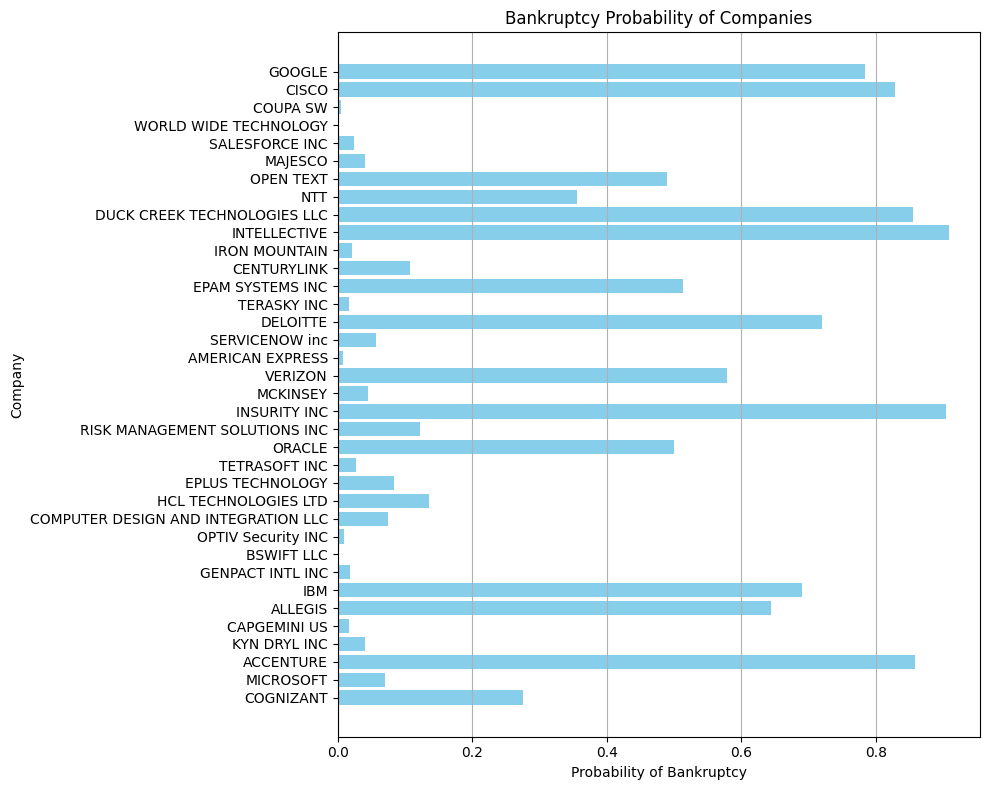

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'new_samples_df_prob' is your DataFrame and the last column contains the bankruptcy probabilities
# Extracting company names from the original list for labeling purposes
companies_list=pd.read_excel("Company_list.xlsx")
company_names = companies_list['Company'].values

# Extracting bankruptcy probabilities from the last column of the DataFrame
bankruptcy_probabilities = new_samples_df_prob.iloc[:, -1].values

# Creating the plot
plt.figure(figsize=(10, 8))  # Set the figure size as needed
plt.barh(company_names, bankruptcy_probabilities, color='skyblue')
plt.xlabel('Probability of Bankruptcy')
plt.ylabel('Company')
plt.title('Bankruptcy Probability of Companies')
plt.grid(axis='x')  # Add a grid on the x-axis for better readability

# Display the plot
plt.tight_layout()  # Adjust the layout to make room for the labels
plt.show()

In [ ]:
new_samples_df_prob.to_csv("final36prob.csv")